/home/elliot/Projects/data-science-project/backend/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/elliot/Projects/data-science-project/backend/env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


2023-10-31 22:00:00    2.632698
Freq: h, dtype: float64


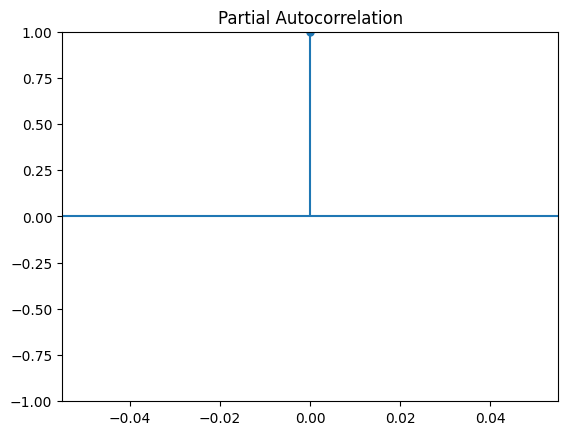

In [7]:
import statsmodels.api as sm
import pandas as pd

# There are over 500 stations
# and this is a proof of concept
# so we will only take a few stations
stations = ['Kamppi (M)']

data = pd.read_csv('../datasets/' + stations[0] + '_hourly_aggregate.csv')
data['Departure'] = pd.to_datetime(data['Departure'], format='mixed')

weather_df = pd.read_csv('../datasets/weather_hourly_helsinki.csv')
weather_df = weather_df.loc[1:, :]
weather_df.columns = weather_df.iloc[0]
weather_df = weather_df.loc[2:, :]
weather_df['time'] = pd.to_datetime(weather_df['time'], format='mixed')

data['trip_I'] = data['trip'].shift(periods=24) - data['trip']
data = pd.merge(weather_df, data, how='inner', left_on='time', right_on='Departure')
data = data.drop(['time'], axis=1)
data.set_index(data['temperature_2m (°C)'], inplace=True)
data.set_index(data['rain (mm)'], inplace=True)
data.set_index(data['Departure'], inplace=True)

data['temperature_2m (°C)'] = pd.to_numeric(data['temperature_2m (°C)'], errors='coerce')
data['rain (mm)'] = pd.to_numeric(data['rain (mm)'], errors='coerce')
data['trip'] = pd.to_numeric(data['trip'], errors='coerce')

sm.graphics.tsa.plot_pacf(data['trip_I'], lags=200, method="ywm")
data = data.dropna(axis=1)

mod = sm.tsa.statespace.SARIMAX(data['trip'], order=(1,1,1), seasonal_order = (0,1,0,24), exog=data[['temperature_2m (°C)', 'rain (mm)']])
res = mod.fit(disp=False)
print(res.forecast('2023-10-31 22:00:00', exog=[1.0, 0.0]))